In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image
import json

# Set device and create output directory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create output directory for generated images
os.makedirs("generated_images", exist_ok=True)

Using device: cuda


In [3]:
print("CUDA Available: ", torch.cuda.is_available())
print("GPU: ", torch.cuda.get_device_name(0))

CUDA Available:  True
GPU:  NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
# Hyperparameters
lr = 0.0002
batch_size = 64
image_size = 64
channels_img = 3  # RGB images
z_dim = 100
num_epochs = 10
features_gen = 64
features_disc = 64

In [5]:
image_folder = 'D:\\LCIT\\Sem - 3\\2007-DL\\week-9\\assignment-3\\photos'
json_file = 'D:\\LCIT\\Sem - 3\\2007-DL\\week-9\\assignment-3\\photos.json'
label_filter = 'food'

In [6]:
class YelpDataset(Dataset):
    def __init__(self, image_folder, json_file, label_filter, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.label_filter = label_filter

        # Load and filter images based on labels from the JSON file
        self.image_files = []
        with open(json_file, 'r') as f:
            for line in f:  # Process each line as a JSON object
                try:
                    entry = json.loads(line.strip())  # Parse JSON
                    if entry.get('label') == self.label_filter:  # Check label
                        image_filename = entry['photo_id'] + '.jpg'  # Construct image filename
                        image_path = os.path.join(image_folder, image_filename)
                        if os.path.isfile(image_path):  # Ensure the image file exists
                            try:
                                # Check image integrity
                                with Image.open(image_path) as img:
                                    img.verify()
                                self.image_files.append(image_filename)
                            except Exception as e:
                                print(f"Skipping corrupted image {image_filename}: {str(e)}")
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON line: {line.strip()} -> {str(e)}")

        print(f"Found {len(self.image_files)} valid images with label '{self.label_filter}'")
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        while True:
            try:
                img_path = os.path.join(self.image_folder, self.image_files[idx])
                image = Image.open(img_path).convert('RGB')  # Open image
                if self.transform:
                    image = self.transform(image)  # Apply transformations
                return image
            except Exception as e:
                print(f"Error loading image {self.image_files[idx]}: {str(e)}")
                idx = (idx + 1) % len(self.image_files)  # Move to the next image

In [7]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * channels_img, [0.5] * channels_img),
])

In [8]:
dataset = YelpDataset(image_folder=image_folder, json_file=json_file, label_filter=label_filter, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Skipping corrupted image ydm3g1wUWSxJnMPgHk2JhQ.jpg: cannot identify image file 'D:\\LCIT\\Sem - 3\\2007-DL\\week-9\\assignment-3\\photos\\ydm3g1wUWSxJnMPgHk2JhQ.jpg'
Skipping corrupted image JGpfPj8VEvnq1B-Xqr3w-A.jpg: cannot identify image file 'D:\\LCIT\\Sem - 3\\2007-DL\\week-9\\assignment-3\\photos\\JGpfPj8VEvnq1B-Xqr3w-A.jpg'
Skipping corrupted image bf3ymV0YgP7B6rEoriaU2w.jpg: cannot identify image file 'D:\\LCIT\\Sem - 3\\2007-DL\\week-9\\assignment-3\\photos\\bf3ymV0YgP7B6rEoriaU2w.jpg'
Skipping corrupted image juDNZOOnkgG3QINFrulsAg.jpg: cannot identify image file 'D:\\LCIT\\Sem - 3\\2007-DL\\week-9\\assignment-3\\photos\\juDNZOOnkgG3QINFrulsAg.jpg'
Skipping corrupted image 9X4YPM8nYFjf7hY8xUdc6Q.jpg: cannot identify image file 'D:\\LCIT\\Sem - 3\\2007-DL\\week-9\\assignment-3\\photos\\9X4YPM8nYFjf7hY8xUdc6Q.jpg'
Skipping corrupted image N6hL8FQ84A2DznF2S2Lp7g.jpg: cannot identify image file 'D:\\LCIT\\Sem - 3\\2007-DL\\week-9\\assignment-3\\photos\\N6hL8FQ84A2DznF2S2Lp7g.jpg

In [9]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),  # 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # 32x32
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(), 
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )

    def forward(self, x):
        return self.gen(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [10]:
# Initialize networks
gen = Generator(z_dim, channels_img, features_gen).to(device)
disc = Discriminator(channels_img, features_disc).to(device)

# Optimizers
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

In [11]:
# Training
print("Starting Training...")
for epoch in range(num_epochs):
    for batch_idx, real in enumerate(loader):
        real = real.to(device)
        batch_size = real.shape[0]
        
        # Train Discriminator
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = gen(noise)
        
        # Real images
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        
        # Fake images
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        # Total discriminator loss
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()
        
        # Train Generator
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        # Print losses oc
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch [{batch_idx}/{len(loader)}] "
                f"Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}"
            )

print("Training finished!")

# Generate images after training is complete
print("Generating images...")
gen.eval()  # Set generator to evaluation mode
with torch.no_grad():
    for i in range(5):  # Generate 5 different sets of images
        noise = torch.randn(16, z_dim, 1, 1).to(device)  
        fake = gen(noise)
        save_image(fake, f"generated_images/final_generated_set_{i+1}.png", normalize=True, nrow=4)
print("Image generation completed!")

Starting Training...
Epoch [0/10] Batch [0/1689] Loss D: 0.8187, Loss G: 3.4286
Epoch [0/10] Batch [100/1689] Loss D: 0.6851, Loss G: 1.1483
Epoch [0/10] Batch [200/1689] Loss D: 0.5485, Loss G: 4.6806
Epoch [0/10] Batch [300/1689] Loss D: 0.3783, Loss G: 3.9293
Epoch [0/10] Batch [400/1689] Loss D: 0.1949, Loss G: 2.9737
Epoch [0/10] Batch [500/1689] Loss D: 0.5536, Loss G: 2.2130
Epoch [0/10] Batch [600/1689] Loss D: 0.3876, Loss G: 2.6684
Epoch [0/10] Batch [700/1689] Loss D: 0.4411, Loss G: 2.1458
Epoch [0/10] Batch [800/1689] Loss D: 0.2890, Loss G: 2.8282
Epoch [0/10] Batch [900/1689] Loss D: 0.3270, Loss G: 2.9992
Epoch [0/10] Batch [1000/1689] Loss D: 0.4959, Loss G: 5.3678
Epoch [0/10] Batch [1100/1689] Loss D: 0.2594, Loss G: 2.7980
Epoch [0/10] Batch [1200/1689] Loss D: 0.3871, Loss G: 3.7193
Epoch [0/10] Batch [1300/1689] Loss D: 0.6200, Loss G: 3.5870
Epoch [0/10] Batch [1400/1689] Loss D: 0.2200, Loss G: 2.1680
Epoch [0/10] Batch [1500/1689] Loss D: 0.2790, Loss G: 3.1903

In [12]:
import torchvision.utils as vutils

def show_all_generated_images(fake):
    grid = vutils.make_grid(fake, nrow=int(fake.shape[0] ** 0.5), padding=2, normalize=True)
    vutils.save_image(grid, 'generated_images.png')

show_all_generated_images(fake)

In [13]:
import torchvision.utils as vutils
from IPython.display import Image

def show_all_generated_images(fake):
    grid = vutils.make_grid(fake, nrow=int(fake.shape[0] ** 0.5), padding=2, normalize=True)
    vutils.save_image(grid, 'generated_images.png')
    Image(filename='generated_images.png')

show_all_generated_images(fake)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

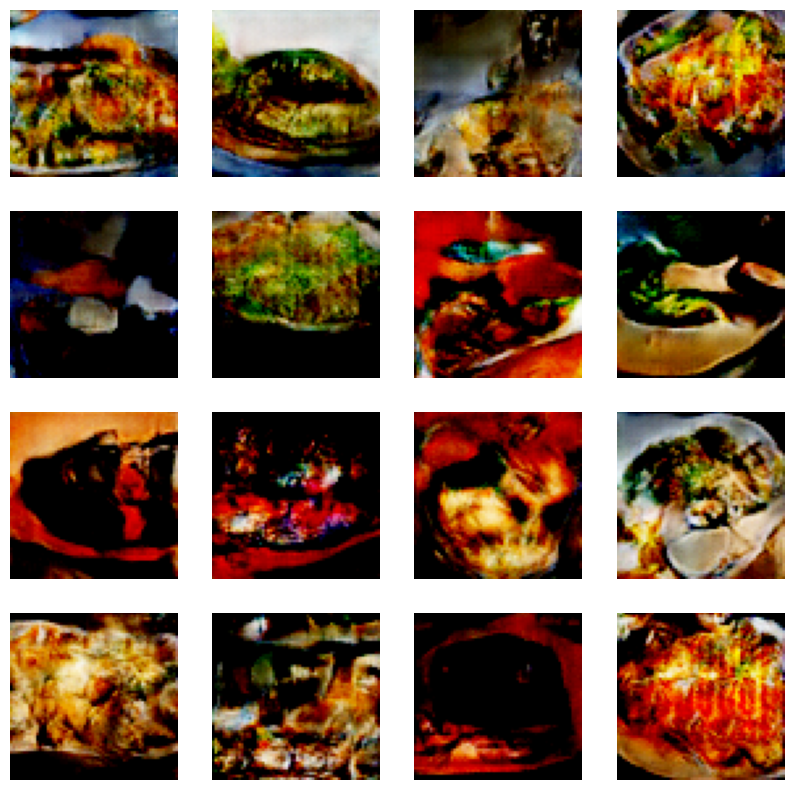

In [14]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
%matplotlib inline

def show_all_generated_images(fake):
    num_images = fake.shape[0]
    cols = int(num_images ** 0.5)
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i in range(fake.shape[0]):
        ax = axes[i // cols, i % cols]
        ax.imshow(fake[i].cpu().permute(1, 2, 0).numpy())
        ax.axis('off')
    plt.show()

show_all_generated_images(fake)

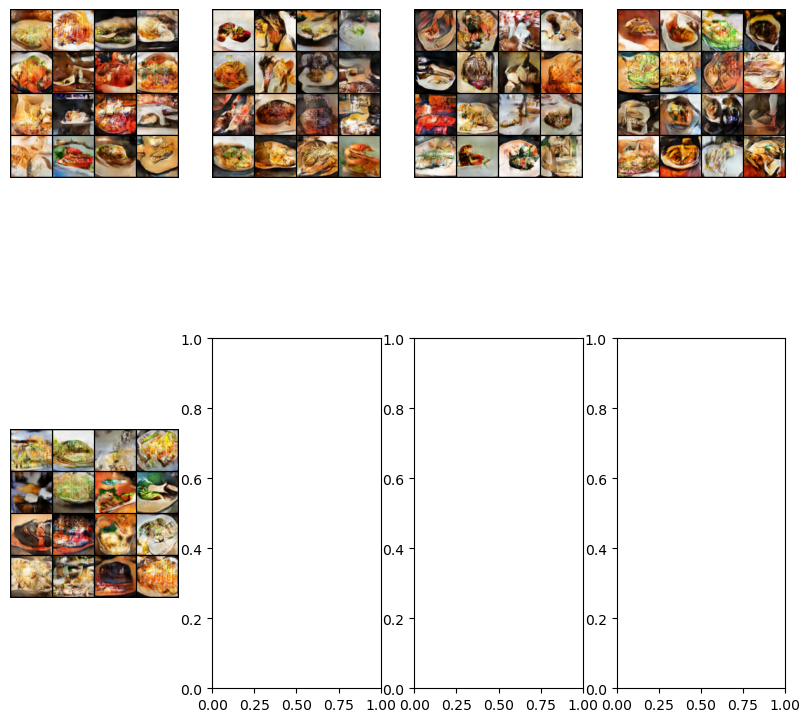

In [16]:
import matplotlib.pyplot as plt
import os
%matplotlib inline

def show_all_generated_images():
    folder_path = 'D:\\LCIT\\Sem - 3\\2007-DL\\week-12\\generated_images'
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    num_images = len(image_files)
    cols = 4
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, image_file in enumerate(image_files):
        ax = axes[i // cols, i % cols]
        ax.imshow(plt.imread(os.path.join(folder_path, image_file)))
        ax.axis('off')
    plt.show()

show_all_generated_images()

In [20]:
import torch

# Assuming your generator and discriminator are named as `generator` and `discriminator`
generator_path = "generator.pth"
discriminator_path = "discriminator.pth"

# Save the generator
torch.save(gen.state_dict(), generator_path)

# Save the discriminator (optional)
torch.save(disc.state_dict(), discriminator_path)

print(f"Generator saved to {generator_path}")
print(f"Discriminator saved to {discriminator_path}")


Generator saved to generator.pth
Discriminator saved to discriminator.pth


In [24]:
import torch

# Save the complete models (architecture + weights)
generator_path = "generator_full.pth"
discriminator_path = "discriminator_full.pth"

# Save complete models, not just state_dict
torch.save(gen, generator_path)
torch.save(disc, discriminator_path)

print(f"Complete generator saved to {generator_path}")
print(f"Complete discriminator saved to {discriminator_path}")

# Create a zip file containing both models
import shutil
shutil.make_archive('dcgan_models_complete', 'zip', '.', '*.pth')

Complete generator saved to generator_full.pth
Complete discriminator saved to discriminator_full.pth


OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: '*.pth'

In [25]:
import shutil
import os

# Create a zip file containing only the .pth files
pth_files = [f for f in os.listdir('.') if f.endswith('.pth')]

# Create a temporary directory to store the files to be zipped
os.makedirs('temp_models', exist_ok=True)
for file in pth_files:
    shutil.copy(file, 'temp_models')

# Create the zip archive
shutil.make_archive('dcgan_models_complete', 'zip', 'temp_models')

# Clean up the temporary directory
shutil.rmtree('temp_models')